In [1]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore') 

import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import save_image

In [2]:
!nvidia-smi

Sun Mar 12 18:21:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   25C    P8     7W / 320W |   4254MiB / 10018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# !pip install gdown
# import gdown 
# google_path = 'https://drive.google.com/uc?id='
# file_id = '17MHP5y2PwDAnVy05AglJQYotWfqOizpB'
# output_name = 'open.zip'
# gdown.download(google_path+file_id,output_name,quiet=False)


In [4]:
!pwd

/home/Dacon_Samsung


In [5]:
# !unzip open.zip -d /data/dacon/Samsung_AI_2022/data

In [6]:
CFG = {
    'WIDTH':48,
    'HEIGHT':72,
    'EPOCHS':30,
    'LEARNING_RATE':1e-5,
    'BATCH_SIZE':64,
    'SEED':123
}

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

In [9]:
class CustomDataset(Dataset):
    def __init__(self, sem_path_list, train_path_list, simulation_depth_paths):
        self.sem_path_list = sem_path_list
        self.train_path_list = train_path_list
        self.dep_path_list = simulation_depth_paths
        
    def __getitem__(self, index):
        sem_path = self.sem_path_list[index]
        sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)
        sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
        sem_img = sem_img / 255.
        
        dep_path = self.dep_path_list[index]
        dep_img = cv2.imread(dep_path, cv2.IMREAD_GRAYSCALE)
        dep_img = np.expand_dims(dep_img, axis=-1).transpose(2,0,1)
        dep_img = dep_img / 255.
        
        idx = index % len(self.train_path_list)
        train_path = self.train_path_list[idx]
        train_img = cv2.imread(train_path, cv2.IMREAD_GRAYSCALE)
        train_img = np.expand_dims(train_img, axis=-1).transpose(2,0,1)
        train_img = train_img / 255.
        
        return torch.Tensor(sem_img), torch.Tensor(dep_img), torch.Tensor(train_img) # B,C,H,W
    
    def __len__(self):
        return len(self.sem_path_list)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
                        nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
                        nn.LeakyReLU())

        self.cnn_layer2 = nn.Sequential(
                                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                nn.LeakyReLU())

        self.cnn_layer3 = nn.Sequential(
                                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                                nn.LeakyReLU())
            
        self.cnn_layer4 = nn.Sequential(
                                nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0),
                                nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.cnn_layer3(output)
        output = self.cnn_layer4(output)
        

        return output

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 3) # 합성곱 연산 (입력 채널 수: 3, 출력 채널 수: 6, 필터 크기: 5x5, stride=1(default))
#         self.pool1 = nn.MaxPool2d(2,2) # 합성곱 연산 (필터크기 2x2, stride=2)
        self.conv2 = nn.Conv2d(128, 256, 3) # 합성곱 연산 (입력 채널 수: 6, 출력 채널수: 16, 필터 크기: 5x5, stride=1(default))
        self.pool2 = nn.MaxPool2d(2, 2) # 합성곱 연산 (필터크기 2x2, stride=2)
        self.conv3 = nn.Conv2d(256, 16, 3) # 합성곱 연산 (입력 채널 수: 6, 출력 채널수: 16, 필터 크기: 5x5, stride=1(default))
        self.pool3 = nn.MaxPool2d(2, 2) # 합성곱 연산 (필터크기 2x2, stride=2)
        self.fc1 = nn.Linear(16 * 16 * 10, 512) # 5x5 피쳐맵 16개를 일렬로 피면 16*5*5개의 노드가 생성됨.
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU -> pool1
        x = self.pool2(F.relu(self.conv2(x))) # conv2 -> ReLU -> pool2
        x = self.pool3(F.relu(self.conv3(x))) # conv2 -> ReLU -> pool2
#         print(x.shape)
        x = x.view(-1, 16 * 16 * 10) # 5x5 피쳐맵 16개를 일렬로 만든다.
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x


In [12]:
simulation_sem_paths = sorted(glob.glob('./data/simulation_data/SEM/Case_3/*/*itr0.png')+ glob.glob('./data/simulation_data/SEM/Case_3/*/*itr1.png'))
simulation_depth_paths = sorted(glob.glob('./data/simulation_data/Depth/Case_3/*/*.png')+glob.glob('./data/simulation_data/Depth/Case_3/*/*.png'))
simulation_train_paths = sorted(glob.glob('./data/train/SEM/Depth_130/*/*.png'))
data_len = len(simulation_sem_paths)

train_idx = np.int_(np.random.choice(data_len, data_len, replace=False))
train_idx

train_sem_paths = list(np.array(simulation_sem_paths)[train_idx[:np.int(data_len*0.8)]])
train_tr_paths = list(np.array(simulation_train_paths)[train_idx[:np.int(data_len*0.8)] % len(simulation_train_paths)])
train_dep_paths = list(np.array(simulation_depth_paths)[train_idx[:np.int(data_len*0.8)]])


val_sem_paths = list(np.array(simulation_sem_paths)[train_idx[np.int(data_len*0.8):]])
val_dep_paths = list(np.array(simulation_depth_paths)[train_idx[np.int(data_len*0.8):]])
val_tr_paths = list(np.array(simulation_train_paths)[train_idx[np.int(data_len*0.8):]% len(simulation_train_paths)])

batch_size = CFG['BATCH_SIZE']

train_dataset = CustomDataset(train_sem_paths, train_tr_paths, train_dep_paths)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

val_dataset = CustomDataset(val_sem_paths, val_tr_paths, val_dep_paths)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr= CFG["LEARNING_RATE"])
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr= CFG["LEARNING_RATE"])

  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [1/30] Batch [500/542] Discriminator loss: 0.648643970489502 Generator loss: 0.7544399499893188


  0%|          | 0/136 [00:00<?, ?it/s]

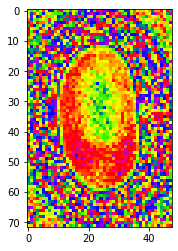

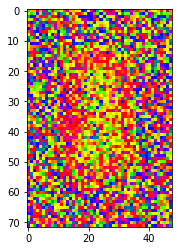

Epoch: 1, Discriminator loss: 0.1466854056891273
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [2/30] Batch [500/542] Discriminator loss: 0.6795922517776489 Generator loss: 0.7377687692642212


  0%|          | 0/136 [00:00<?, ?it/s]

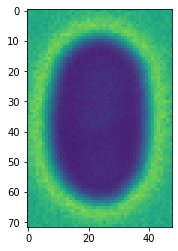

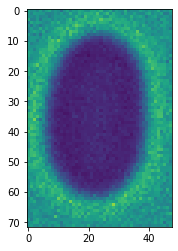

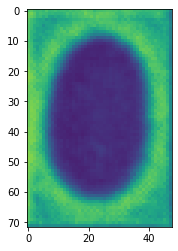

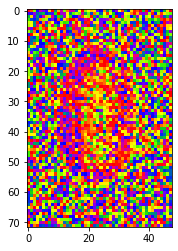

Epoch: 2, Discriminator loss: 0.1584102081901887


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [3/30] Batch [500/542] Discriminator loss: 0.6769510507583618 Generator loss: 0.7182770371437073


  0%|          | 0/136 [00:00<?, ?it/s]

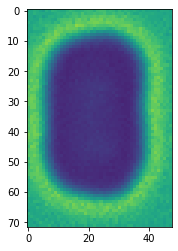

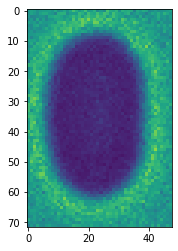

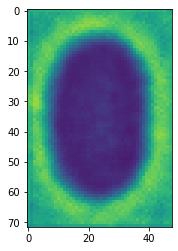

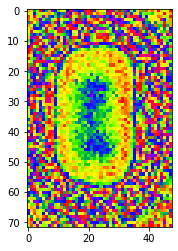

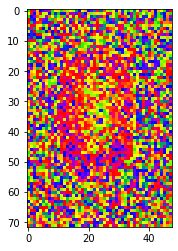

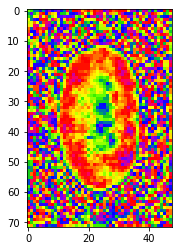

Epoch: 3, Discriminator loss: 0.17770206818685813


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [4/30] Batch [500/542] Discriminator loss: 0.6584621667861938 Generator loss: 0.7229806184768677


  0%|          | 0/136 [00:00<?, ?it/s]

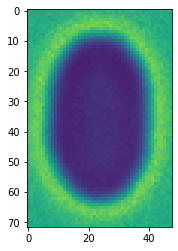

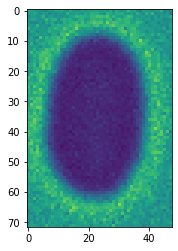

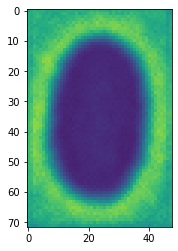

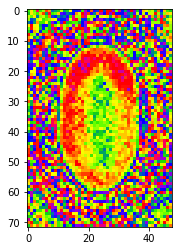

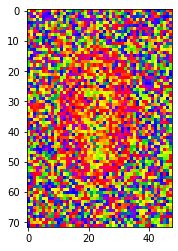

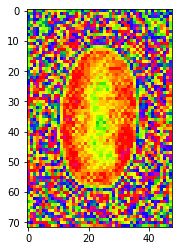

Epoch: 4, Discriminator loss: 0.15920675414450028


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [5/30] Batch [500/542] Discriminator loss: 0.6229908466339111 Generator loss: 0.7980679273605347


  0%|          | 0/136 [00:00<?, ?it/s]

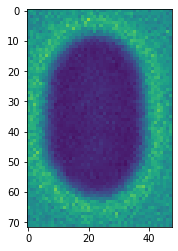

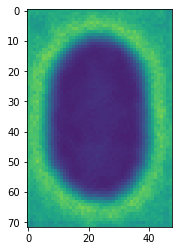

Epoch: 5, Discriminator loss: 0.132967420579756
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [6/30] Batch [500/542] Discriminator loss: 0.5831373333930969 Generator loss: 0.8255274891853333


  0%|          | 0/136 [00:00<?, ?it/s]

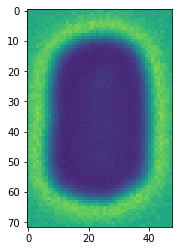

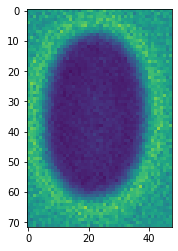

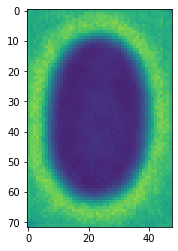

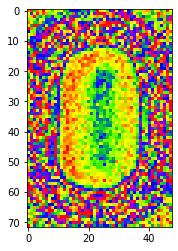

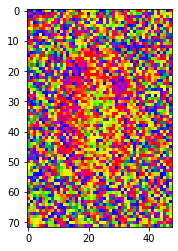

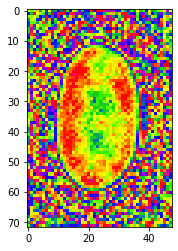

Epoch: 6, Discriminator loss: 0.10054656600250918
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [7/30] Batch [500/542] Discriminator loss: 0.5605148077011108 Generator loss: 0.854668378829956


  0%|          | 0/136 [00:00<?, ?it/s]

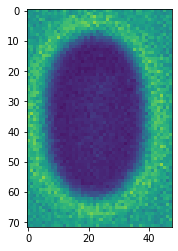

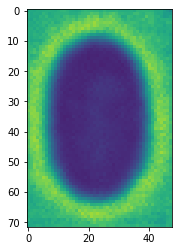

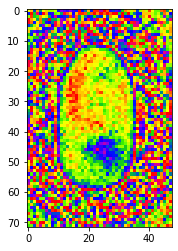

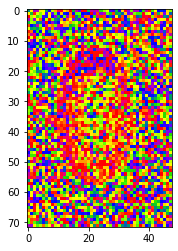

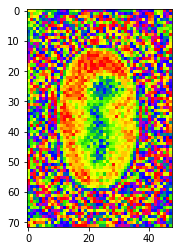

Epoch: 7, Discriminator loss: 0.06365935208604616
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [8/30] Batch [500/542] Discriminator loss: 0.5596191883087158 Generator loss: 0.9369383454322815


  0%|          | 0/136 [00:00<?, ?it/s]

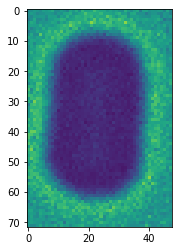

Epoch: 8, Discriminator loss: 0.05085329360821668
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [9/30] Batch [500/542] Discriminator loss: 0.5330551862716675 Generator loss: 1.0200798511505127


  0%|          | 0/136 [00:00<?, ?it/s]

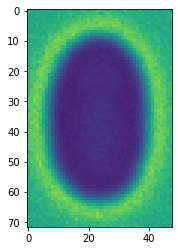

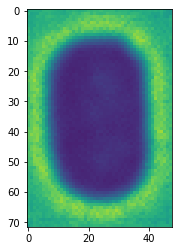

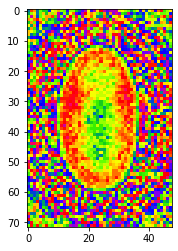

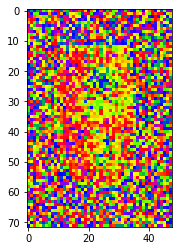

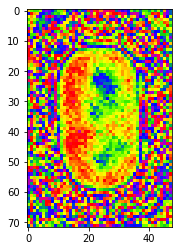

Epoch: 9, Discriminator loss: 0.038657851298065746
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [10/30] Batch [500/542] Discriminator loss: 0.5117321014404297 Generator loss: 1.1264914274215698


  0%|          | 0/136 [00:00<?, ?it/s]

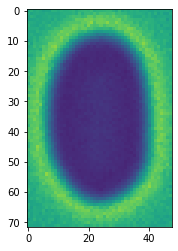

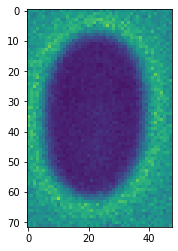

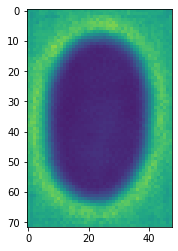

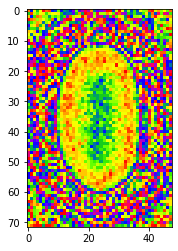

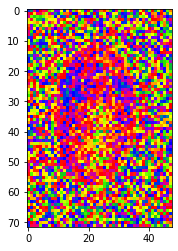

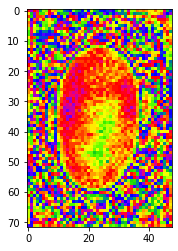

Epoch: 10, Discriminator loss: 0.030314778361250374
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [11/30] Batch [500/542] Discriminator loss: 0.534835696220398 Generator loss: 0.9634338021278381


  0%|          | 0/136 [00:00<?, ?it/s]

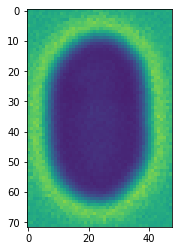

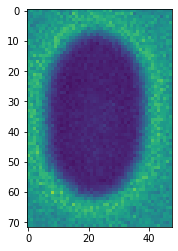

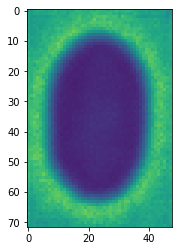

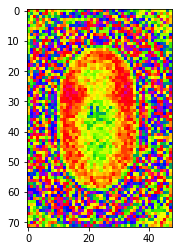

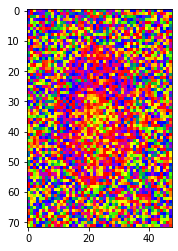

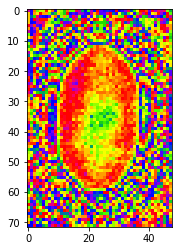

Epoch: 11, Discriminator loss: 0.029474780511330154
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [12/30] Batch [500/542] Discriminator loss: 0.47626179456710815 Generator loss: 1.0225657224655151


  0%|          | 0/136 [00:00<?, ?it/s]

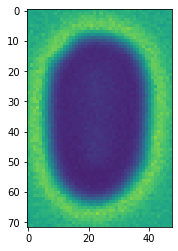

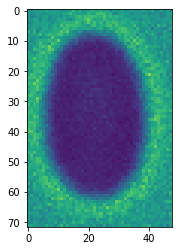

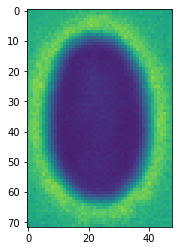

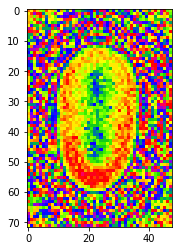

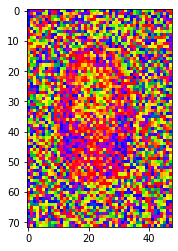

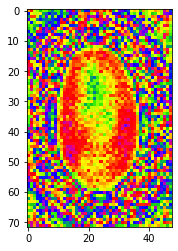

Epoch: 12, Discriminator loss: 0.01842243892743307
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [13/30] Batch [500/542] Discriminator loss: 0.4430554509162903 Generator loss: 1.272837519645691


  0%|          | 0/136 [00:00<?, ?it/s]

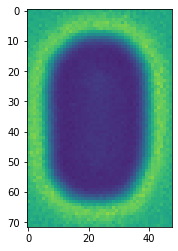

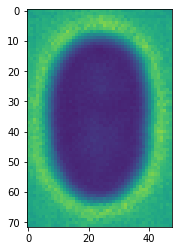

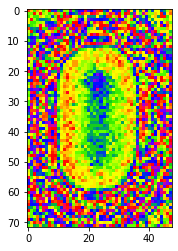

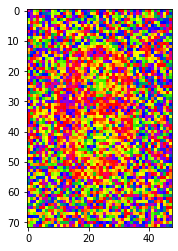

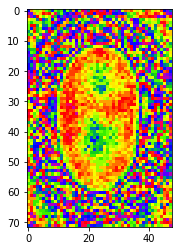

Epoch: 13, Discriminator loss: 0.02330960037515444


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [14/30] Batch [500/542] Discriminator loss: 0.5196645259857178 Generator loss: 0.814260721206665


  0%|          | 0/136 [00:00<?, ?it/s]

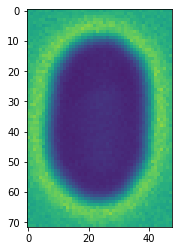

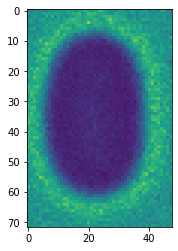

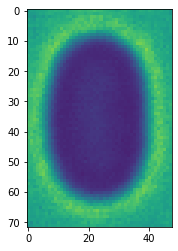

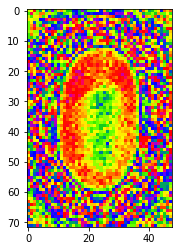

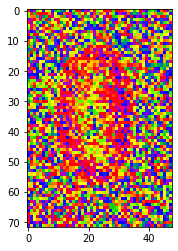

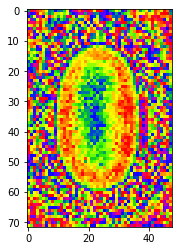

Epoch: 14, Discriminator loss: 0.017682568444048658
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [15/30] Batch [500/542] Discriminator loss: 0.5141175985336304 Generator loss: 1.1697962284088135


  0%|          | 0/136 [00:00<?, ?it/s]

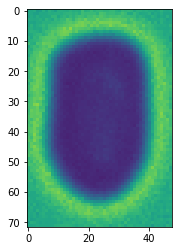

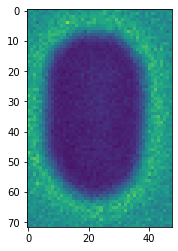

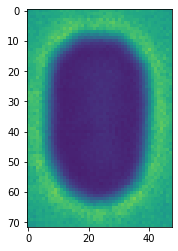

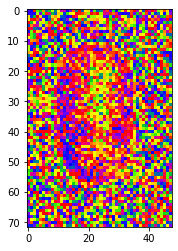

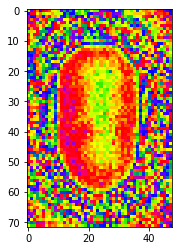

Epoch: 15, Discriminator loss: 0.019286304821862894


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [16/30] Batch [500/542] Discriminator loss: 0.5069472789764404 Generator loss: 1.0214000940322876


  0%|          | 0/136 [00:00<?, ?it/s]

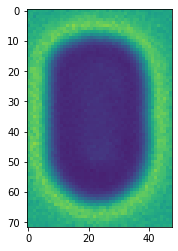

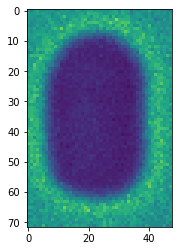

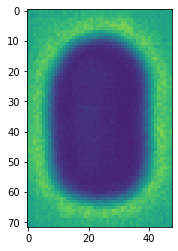

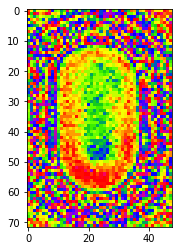

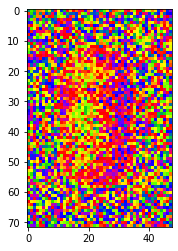

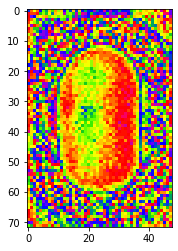

Epoch: 16, Discriminator loss: 0.01877508367247441


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [17/30] Batch [500/542] Discriminator loss: 0.443389892578125 Generator loss: 1.1793761253356934


  0%|          | 0/136 [00:00<?, ?it/s]

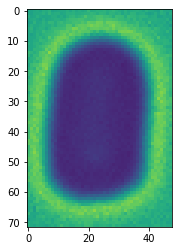

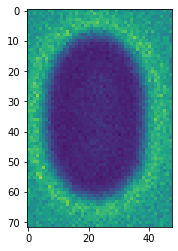

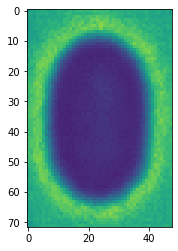

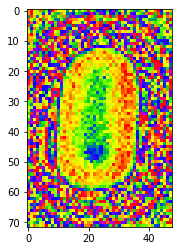

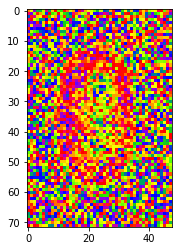

Epoch: 17, Discriminator loss: 0.01902860633152373


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [18/30] Batch [500/542] Discriminator loss: 0.5120530724525452 Generator loss: 1.0034523010253906


  0%|          | 0/136 [00:00<?, ?it/s]

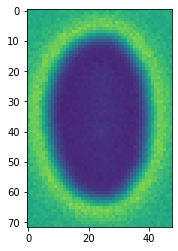

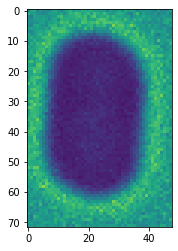

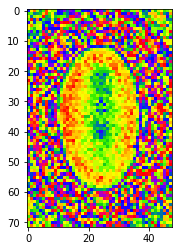

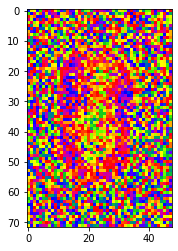

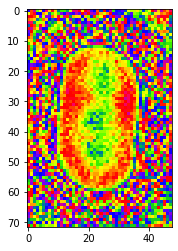

Epoch: 18, Discriminator loss: 0.027985986979568705


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [19/30] Batch [500/542] Discriminator loss: 0.4546680450439453 Generator loss: 1.3018510341644287


  0%|          | 0/136 [00:00<?, ?it/s]

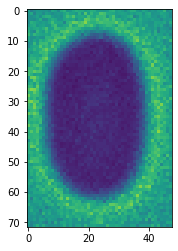

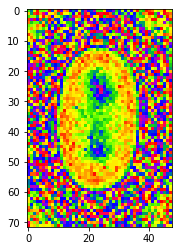

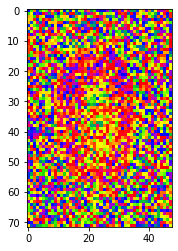

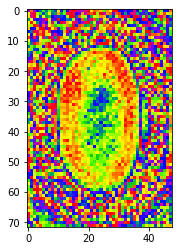

Epoch: 19, Discriminator loss: 0.05180385621155009


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [20/30] Batch [500/542] Discriminator loss: 0.4868776798248291 Generator loss: 1.4015343189239502


  0%|          | 0/136 [00:00<?, ?it/s]

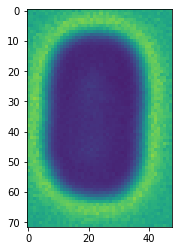

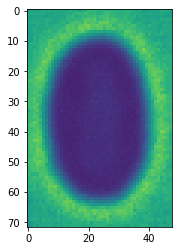

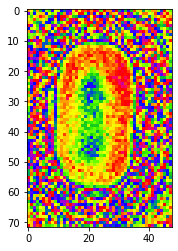

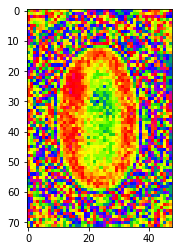

Epoch: 20, Discriminator loss: 0.044007672654355276


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [21/30] Batch [500/542] Discriminator loss: 0.45861199498176575 Generator loss: 1.3448548316955566


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch: 21, Discriminator loss: 0.05334888146642376


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [22/30] Batch [500/542] Discriminator loss: 0.43209773302078247 Generator loss: 1.5482228994369507


  0%|          | 0/136 [00:00<?, ?it/s]

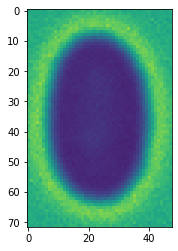

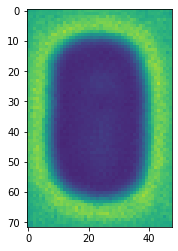

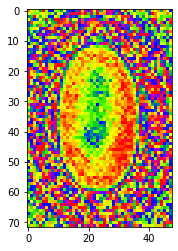

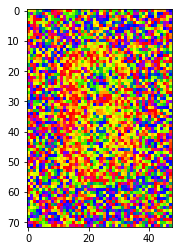

Epoch: 22, Discriminator loss: 0.053090562386547815


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [23/30] Batch [500/542] Discriminator loss: 0.4682368040084839 Generator loss: 1.18051016330719


  0%|          | 0/136 [00:00<?, ?it/s]

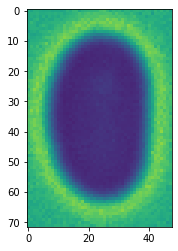

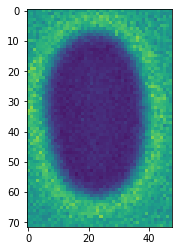

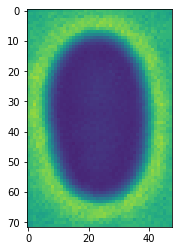

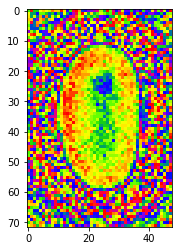

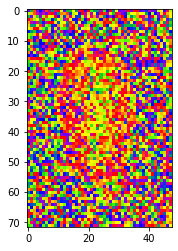

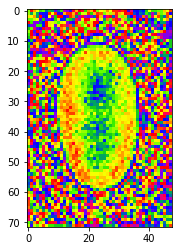

Epoch: 23, Discriminator loss: 0.037356847458902526


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [24/30] Batch [500/542] Discriminator loss: 0.4389561414718628 Generator loss: 1.3118398189544678


  0%|          | 0/136 [00:00<?, ?it/s]

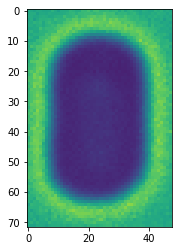

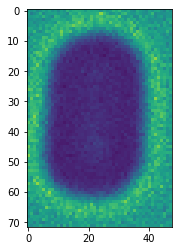

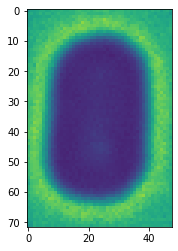

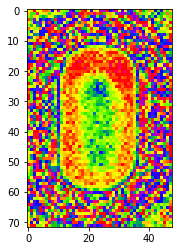

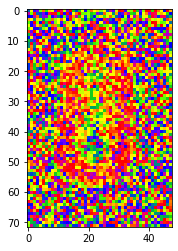

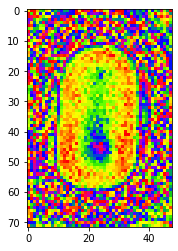

Epoch: 24, Discriminator loss: 0.053060869083685035


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [25/30] Batch [500/542] Discriminator loss: 0.43839067220687866 Generator loss: 1.3269367218017578


  0%|          | 0/136 [00:00<?, ?it/s]

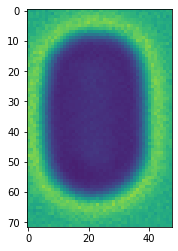

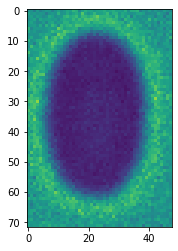

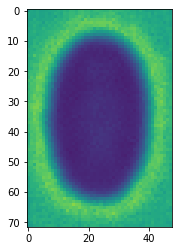

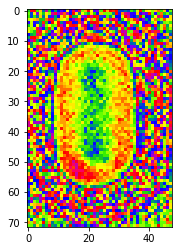

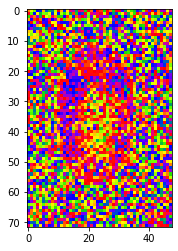

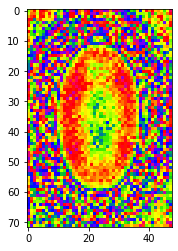

Epoch: 25, Discriminator loss: 0.05390580973642714


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [26/30] Batch [500/542] Discriminator loss: 0.43133655190467834 Generator loss: 1.482458472251892


  0%|          | 0/136 [00:00<?, ?it/s]

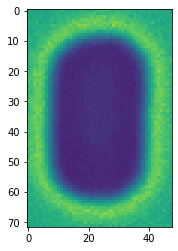

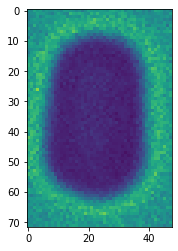

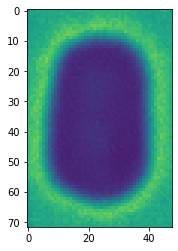

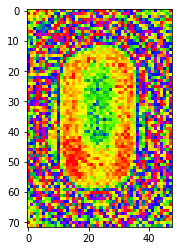

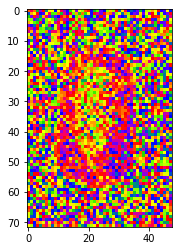

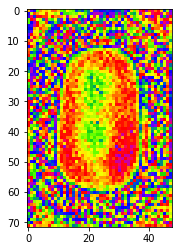

Epoch: 26, Discriminator loss: 0.06900765944053144


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [27/30] Batch [500/542] Discriminator loss: 0.4172123372554779 Generator loss: 1.2537201642990112


  0%|          | 0/136 [00:00<?, ?it/s]

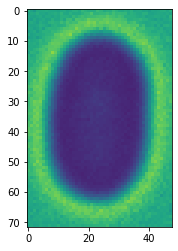

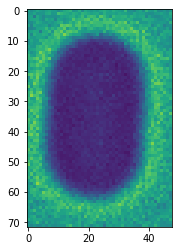

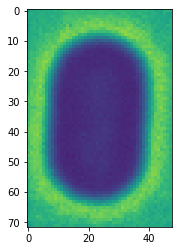

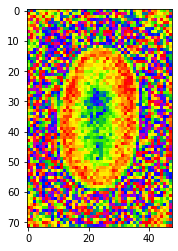

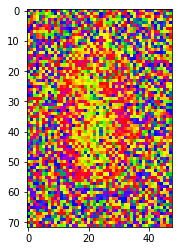

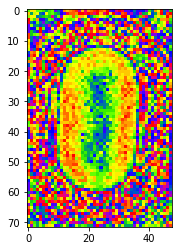

Epoch: 27, Discriminator loss: 0.05454359072096208


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [28/30] Batch [500/542] Discriminator loss: 0.4368278980255127 Generator loss: 1.5427956581115723


  0%|          | 0/136 [00:00<?, ?it/s]

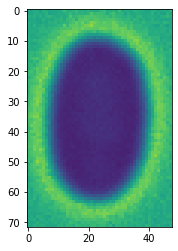

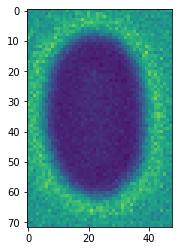

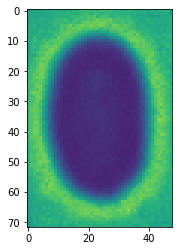

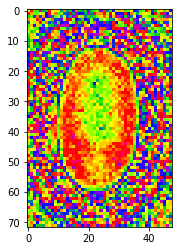

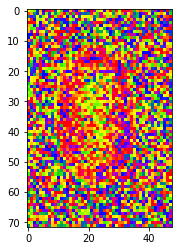

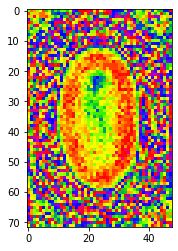

Epoch: 28, Discriminator loss: 0.05802143003572436


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [29/30] Batch [500/542] Discriminator loss: 0.45880433917045593 Generator loss: 1.251460313796997


  0%|          | 0/136 [00:00<?, ?it/s]

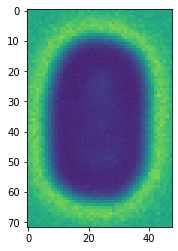

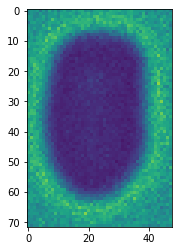

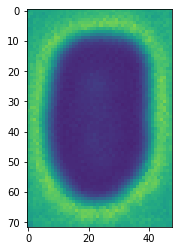

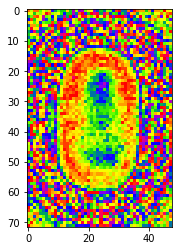

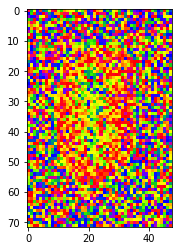

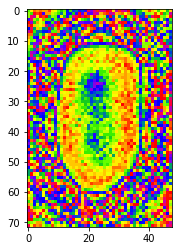

Epoch: 29, Discriminator loss: 0.03804221891743295


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [30/30] Batch [500/542] Discriminator loss: 0.5144239664077759 Generator loss: 1.3988394737243652


  0%|          | 0/136 [00:00<?, ?it/s]

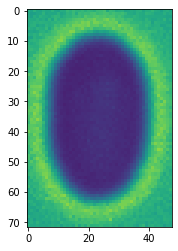

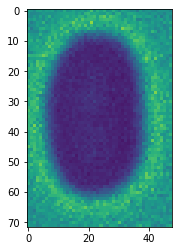

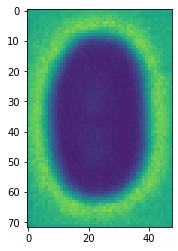

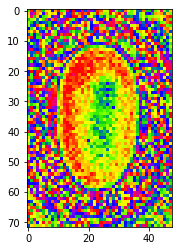

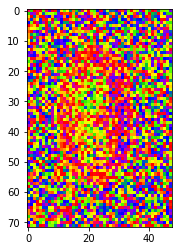

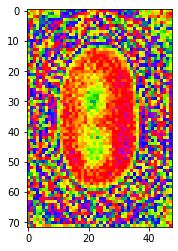

Epoch: 30, Discriminator loss: 0.08977018417242695


In [13]:
criterion = nn.BCELoss()
g_loss_list = []
d_loss_list = []
best_score = 100
best_model_g = None
best_model_d = None
for epoch in range(1, CFG['EPOCHS']+1):
    generator.train()
    discriminator.train()
    
    train_loss = []
    i = 0
    for sem, dep, tr in tqdm(iter(train_loader)):

        tr = tr.float().to(device)
        valid_label = torch.ones((tr.shape[0], 1), device=device, dtype = torch.float32)
        
        z = torch.randn((tr.shape[0], tr.shape[1], tr.shape[2], tr.shape[3]), device = device)
        z = torch.cat([sem.float().to(device), dep.float().to(device),z ], axis=1)        
        gen_img = generator(z)        
        fake_label = torch.zeros((tr.shape[0], 1), device=device, dtype = torch.float32)


        real_loss = criterion(discriminator(tr), valid_label)
        fake_loss = criterion(discriminator(gen_img.detach()), fake_label)
        d_loss = (real_loss + fake_loss) * 0.5

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        g_loss = criterion(discriminator(gen_img), valid_label)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()            

        if (i+1) % 500 == 0:
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            print("Epoch [{}/{}] Batch [{}/{}] Discriminator loss: {} Generator loss: {}".format(epoch, CFG['EPOCHS'], i+1, len(train_loader), d_loss.item(), g_loss.item()))
        i += 1
    if epoch % 1 == 0:
        generator.eval()
        discriminator.eval()
        val_loss = []
        
        with torch.no_grad():
            cnt = 0
            for sem, dep, tr in tqdm(iter(val_loader)):
                tr = tr.float().to(device)
                valid_label = torch.ones((tr.shape[0], 1), device=device, dtype = torch.float32)
                
                z = torch.randn((tr.shape[0], tr.shape[1], tr.shape[2], tr.shape[3]), device = device)
                z = torch.cat([sem.float().to(device), dep.float().to(device), z], axis=1)        
                gen_img = generator(z)    
                fake_label = torch.zeros((tr.shape[0], 1), device=device, dtype = torch.float32)
                
                real_loss = criterion(discriminator(tr), valid_label)
                fake_loss = criterion(discriminator(gen_img.detach()), fake_label)
                val_loss.append(np.abs((real_loss.item() + fake_loss.item())  * 0.5 - 0.5))
                
                cnt+=1
                if cnt == 1:
                    plt.imshow(tr[0][0].cpu().detach().numpy(), vmin= 0, vmax=1)
                    plt.show()
                    plt.imshow(sem[0][0].cpu().detach().numpy(), vmin= 0, vmax=1)
                    plt.show()
                    plt.imshow(gen_img[0][0].cpu().detach().numpy(), vmin= 0, vmax=1)
                    plt.show()
                    plt.imshow(tr[0][0].cpu().detach().numpy()  , cmap = 'prism', vmin= 0, vmax=1)
                    plt.show()
                    plt.imshow(sem[0][0].cpu().detach().numpy()  , cmap = 'prism', vmin= 0, vmax=1)
                    plt.show()
                    plt.imshow(gen_img[0][0].cpu().detach().numpy()  , cmap = 'prism', vmin= 0, vmax=1)
                    plt.show()
        val_error = np.mean(val_loss)
        print("Epoch: {}, Discriminator loss: {}".format(epoch, val_error))
        
        if best_score > val_error:
            best_score = val_error
            torch.save(generator.state_dict(), "./weight/generator_state_dict3.pt")
            torch.save(discriminator.state_dict(), "./weight/discriminator_state_dict3.pt")        
            print("Save!!")

In [14]:
generator = Generator().to(device)
generator.load_state_dict(torch.load('./weight/generator_state_dict3.pt'))

<All keys matched successfully>

In [15]:
simulation_sem_paths[0][:-4]+'_gen.png'

'./data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr0_gen.png'

In [16]:
simulation_sem_paths

['./data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr0.png',
 './data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr1.png',
 './data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0006-01MS_3_itr0.png',
 './data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0006-01MS_3_itr1.png',
 './data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0009-01MS_3_itr0.png',
 './data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0009-01MS_3_itr1.png',
 './data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0029-01MS_1_itr0.png',
 './data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0029-01MS_1_itr1.png',
 './data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0030-01MS_2_itr0.png',
 './data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0030-01MS_2_i

idx: 1 path:  ./data/simulation_data/SEM/Case_3/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr1.png


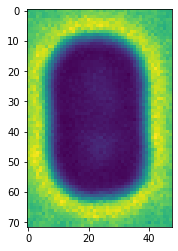

idx: 1001 path:  ./data/simulation_data/SEM/Case_3/80/20201205_031451_NE142400C_RAA0A_1_S01_M0133-01MS_0_itr1.png


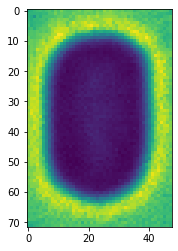

idx: 2001 path:  ./data/simulation_data/SEM/Case_3/80/20201219_205018_NE142400C_RAA0J_2_S13_M0178-01MS_3_itr1.png


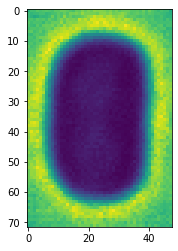

idx: 3001 path:  ./data/simulation_data/SEM/Case_3/80/20210113_072317_NE142400C_RAM0H_1_S01_M0085-01MS_0_itr1.png


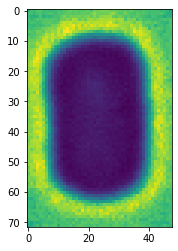

idx: 4001 path:  ./data/simulation_data/SEM/Case_3/80/20210209_031719_NE142400C_RAE14_2_S07_M0113-01MS_2_itr1.png


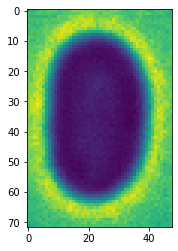

idx: 5001 path:  ./data/simulation_data/SEM/Case_3/80/20210316_080344_NE142400C_RAA21_1_S05_M0214-01MS_1_itr1.png


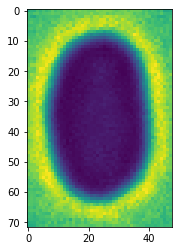

idx: 6001 path:  ./data/simulation_data/SEM/Case_3/81/20201105_031319_NE142400C_RAE05_1_S01_M0192-01MS_3_itr1.png


idx: 7001 path:  ./data/simulation_data/SEM/Case_3/81/20201212_075845_NE142400C_RAM0R_1_S15_M0242-01MS_3_itr1.png


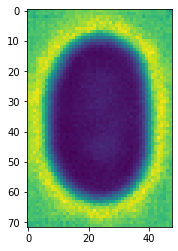

idx: 8001 path:  ./data/simulation_data/SEM/Case_3/81/20210106_093118_NE142400C_RAA0H_1_S02_M0061-01MS_3_itr1.png


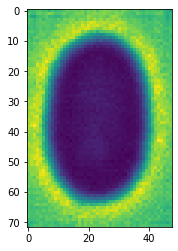

idx: 9001 path:  ./data/simulation_data/SEM/Case_3/81/20210114_072519_NE142400C_RAA14_2_S09_M0206-01MS_2_itr1.png


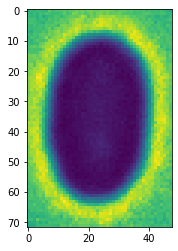

idx: 10001 path:  ./data/simulation_data/SEM/Case_3/81/20210213_030800_NE142400C_RAA0S_1_S01_M0183-01MS_1_itr1.png


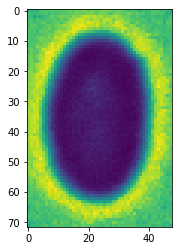

idx: 11001 path:  ./data/simulation_data/SEM/Case_3/81/20210302_082541_NE142400C_RAA0TH_1_S10_M0121-01MS_2_itr1.png


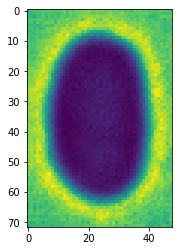

idx: 12001 path:  ./data/simulation_data/SEM/Case_3/81/20210318_110531_NE142400C_RAE12_1_S20_M0152-01MS_3_itr1.png


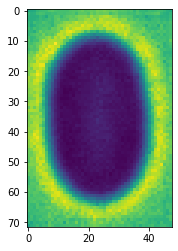

idx: 13001 path:  ./data/simulation_data/SEM/Case_3/82/20201105_031319_NE142400C_RAE05_1_S01_M0214-01MS_1_itr1.png


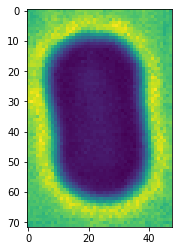

idx: 14001 path:  ./data/simulation_data/SEM/Case_3/82/20201219_130240_NE142400C_RAA0J_2_S02_M0099-01MS_3_itr1.png


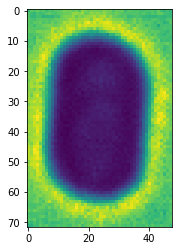

idx: 15001 path:  ./data/simulation_data/SEM/Case_3/82/20210110_172304_NE142400C_RAM1NI_1_S10_M0117-01MS_3_itr1.png


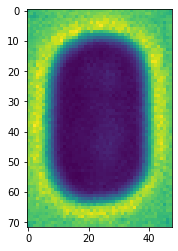

idx: 16001 path:  ./data/simulation_data/SEM/Case_3/82/20210114_183335_NE142400C_RAM1B_1_S03_M0005-01MS_3_itr1.png


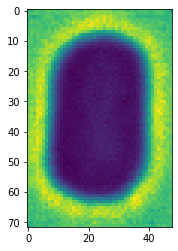

idx: 17001 path:  ./data/simulation_data/SEM/Case_3/82/20210207_103243_NE142400C_RAA1I_63_S06_M0180-01MS_2_itr1.png


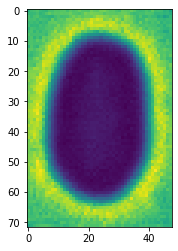

idx: 18001 path:  ./data/simulation_data/SEM/Case_3/82/20210220_101758_NE142400C_RAE0H_1_S01_M0087-01MS_2_itr1.png


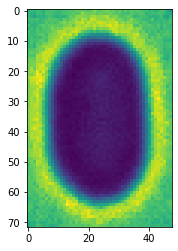

idx: 19001 path:  ./data/simulation_data/SEM/Case_3/82/20210228_090349_NE142400C_RAM2L_1_S06_M0056-01MS_3_itr1.png


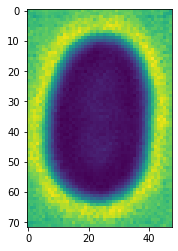

idx: 20001 path:  ./data/simulation_data/SEM/Case_3/82/20210315_025821_NE142400C_RAM1R_1_S05_M0092-01MS_3_itr1.png


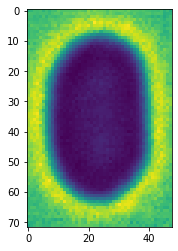

idx: 21001 path:  ./data/simulation_data/SEM/Case_3/82/20210322_032730_NE142400C_RAM2H_1_S06_M0245-01MS_3_itr1.png


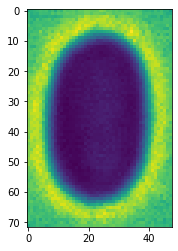

idx: 22001 path:  ./data/simulation_data/SEM/Case_3/83/20201105_031319_NE142400C_RAE05_1_S01_M0021-01MS_0_itr1.png


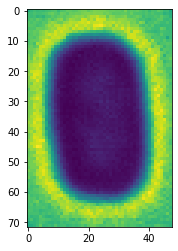

idx: 23001 path:  ./data/simulation_data/SEM/Case_3/83/20201220_014340_NE142400C_RAM0J_1_S01_M0154-01MS_3_itr1.png


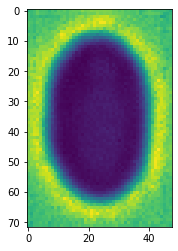

idx: 24001 path:  ./data/simulation_data/SEM/Case_3/83/20210113_043415_NE142400C_RAA0U_1_S01_M0243-01MS_0_itr1.png


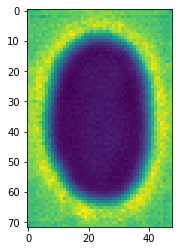

idx: 25001 path:  ./data/simulation_data/SEM/Case_3/83/20210116_114244_NE142400C_RAE0B_1_S02_M0214-01MS_0_itr1.png


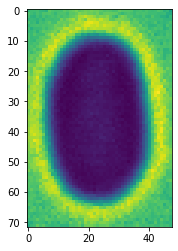

idx: 26001 path:  ./data/simulation_data/SEM/Case_3/83/20210204_203618_NE142400C_RAA1H_1_S07_M0307-01MS_2_itr1.png


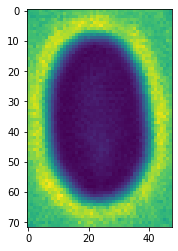

idx: 27001 path:  ./data/simulation_data/SEM/Case_3/83/20210216_090716_NE142400C_RAE0OE_1_S12_M0020-01MS_1_itr1.png


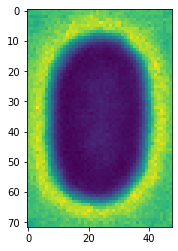

idx: 28001 path:  ./data/simulation_data/SEM/Case_3/83/20210225_175004_NE142400C_RAE0E_1_S01_M0175-01MS_1_itr1.png


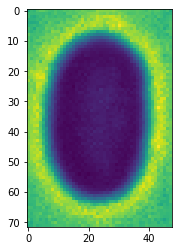

idx: 29001 path:  ./data/simulation_data/SEM/Case_3/83/20210301_060120_NE142400C_RAA1R_1_S05_M0214-01MS_2_itr1.png


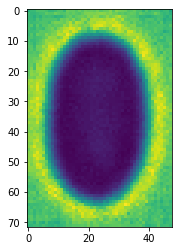

idx: 30001 path:  ./data/simulation_data/SEM/Case_3/83/20210316_080344_NE142400C_RAA21_1_S05_M0377-01MS_0_itr1.png


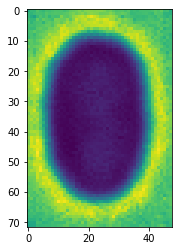

idx: 31001 path:  ./data/simulation_data/SEM/Case_3/83/20210322_032730_NE142400C_RAM2H_1_S06_M0206-01MS_2_itr1.png


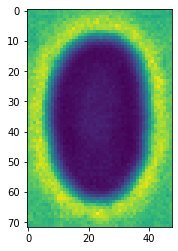

idx: 32001 path:  ./data/simulation_data/SEM/Case_3/83/20210402_155723_NE142400C_RAA0Z_1_S12_M0240-01MS_0_itr1.png


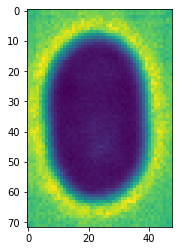

idx: 33001 path:  ./data/simulation_data/SEM/Case_3/84/20201221_123611_NE142400C_RAA07C_2_S11_M0148-01MS_3_itr1.png


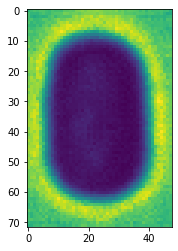

idx: 34001 path:  ./data/simulation_data/SEM/Case_3/84/20210113_072317_NE142400C_RAM0H_1_S01_M0154-01MS_2_itr1.png


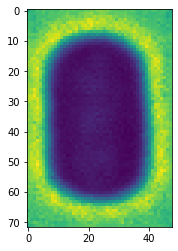

idx: 35001 path:  ./data/simulation_data/SEM/Case_3/84/20210116_114244_NE142400C_RAE0B_1_S02_M0057-01MS_0_itr1.png


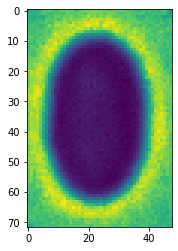

idx: 36001 path:  ./data/simulation_data/SEM/Case_3/84/20210201_091907_NE142400C_RAE0U_1_S01_M0371-01MS_2_itr1.png


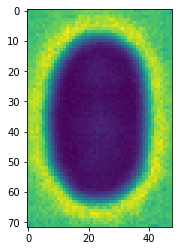

idx: 37001 path:  ./data/simulation_data/SEM/Case_3/84/20210214_041502_NE142400C_RAA0S_2_S02_M0247-01MS_2_itr1.png


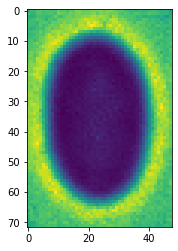

idx: 38001 path:  ./data/simulation_data/SEM/Case_3/84/20210220_234815_NE142400C_RAA1K_1_S01_M0381-01MS_0_itr1.png


idx: 39001 path:  ./data/simulation_data/SEM/Case_3/84/20210227_035705_NE142400C_RAM1A_1_S06_M0341-01MS_0_itr1.png


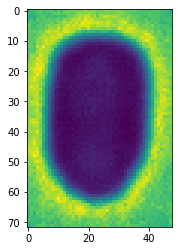

idx: 40001 path:  ./data/simulation_data/SEM/Case_3/84/20210304_165053_NE142400C_RAA26_1_S01_M0302-01MS_3_itr1.png


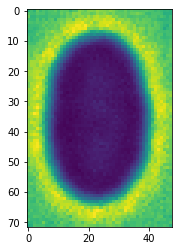

idx: 41001 path:  ./data/simulation_data/SEM/Case_3/84/20210316_101925_NE142400C_RAA1C_1_S07_M0051-01MS_0_itr1.png


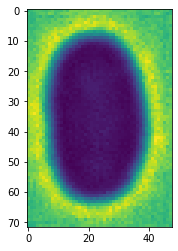

idx: 42001 path:  ./data/simulation_data/SEM/Case_3/84/20210322_035118_NE142400C_RAA2J_1_S07_M0118-01MS_0_itr1.png


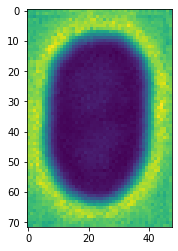

idx: 43001 path:  ./data/simulation_data/SEM/Case_3/84/20210329_235628_NE142400C_RAE09_1_S01_M0369-01MS_0_itr1.png


In [17]:
for idx, i in enumerate(simulation_sem_paths):

    sem_img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
    sem_img = sem_img / 255.
    sem_img = torch.tensor(sem_img, device = device).unsqueeze(0)
    
    dep = cv2.imread(simulation_depth_paths[idx], cv2.IMREAD_GRAYSCALE)
    dep = np.expand_dims(dep, axis=-1).transpose(2,0,1)
    dep = dep / 255.
    dep = torch.tensor(dep, device = device).unsqueeze(0)
    
    
    z = torch.randn((sem_img.shape[0], sem_img.shape[1], sem_img.shape[2], sem_img.shape[3]), device = device)
    z = torch.cat([sem_img.float().to(device), dep.float().to(device), z], axis=1)        
    gen_img = generator(z)
    
    save_image(gen_img[0].cpu().detach(), i[:-4]+'_gen.png')
    
    if idx% 1000 == 1:
        print('idx:', idx, 'path: ', i)
        plt.imshow(gen_img[0][0].cpu().detach().numpy())
        plt.show()

## Case 4

In [18]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

In [19]:
simulation_sem_paths = sorted(glob.glob('./data/simulation_data/SEM/Case_4/*/*itr0.png')+ glob.glob('./data/simulation_data/SEM/Case_4/*/*itr1.png'))
simulation_depth_paths = sorted(glob.glob('./data/simulation_data/Depth/Case_4/*/*.png')+glob.glob('./data/simulation_data/Depth/Case_4/*/*.png'))
simulation_train_paths = sorted(glob.glob('./data/train/SEM/Depth_140/*/*.png'))
data_len = len(simulation_sem_paths)

train_idx = np.int_(np.random.choice(data_len, data_len, replace=False))
train_idx

train_sem_paths = list(np.array(simulation_sem_paths)[train_idx[:np.int(data_len*0.8)]])
train_tr_paths = list(np.array(simulation_train_paths)[train_idx[:np.int(data_len*0.8)] % len(simulation_train_paths)])
train_dep_paths = list(np.array(simulation_depth_paths)[train_idx[:np.int(data_len*0.8)]])


val_sem_paths = list(np.array(simulation_sem_paths)[train_idx[np.int(data_len*0.8):]])
val_dep_paths = list(np.array(simulation_depth_paths)[train_idx[np.int(data_len*0.8):]])
val_tr_paths = list(np.array(simulation_train_paths)[train_idx[np.int(data_len*0.8):]% len(simulation_train_paths)])

batch_size = CFG['BATCH_SIZE']

train_dataset = CustomDataset(train_sem_paths, train_tr_paths, train_dep_paths)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

val_dataset = CustomDataset(val_sem_paths, val_tr_paths, val_dep_paths)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr= CFG["LEARNING_RATE"])
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr= CFG["LEARNING_RATE"])

  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [1/30] Batch [500/542] Discriminator loss: 0.6780529022216797 Generator loss: 0.7186723947525024


  0%|          | 0/136 [00:00<?, ?it/s]

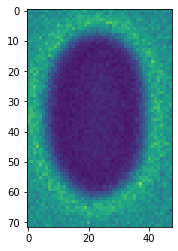

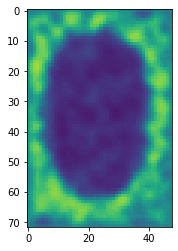

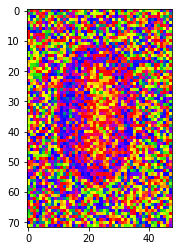

Epoch: 1, Discriminator loss: 0.16420314460992813
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [2/30] Batch [500/542] Discriminator loss: 0.6627182364463806 Generator loss: 0.6835246682167053


  0%|          | 0/136 [00:00<?, ?it/s]

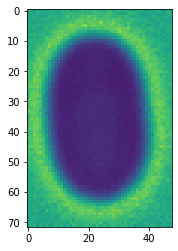

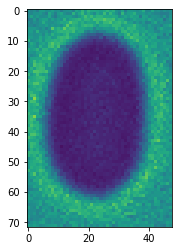

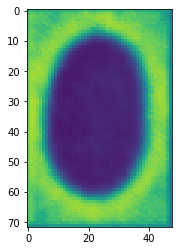

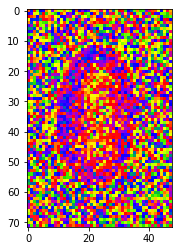

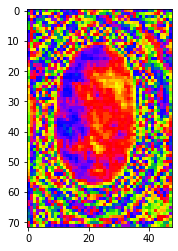

Epoch: 2, Discriminator loss: 0.16508894457536585


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [3/30] Batch [500/542] Discriminator loss: 0.6353027820587158 Generator loss: 0.7518185377120972


  0%|          | 0/136 [00:00<?, ?it/s]

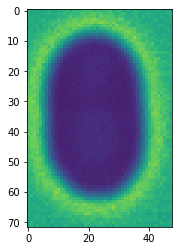

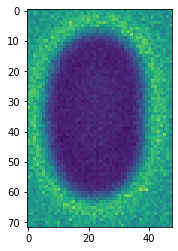

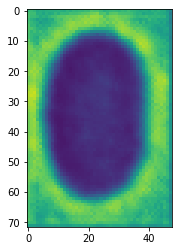

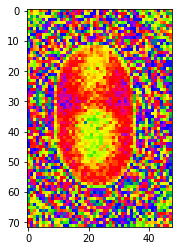

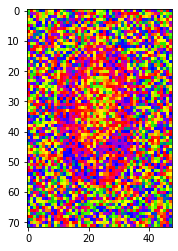

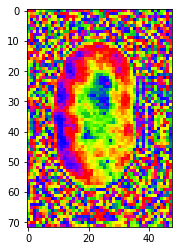

Epoch: 3, Discriminator loss: 0.20124313235282898


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [4/30] Batch [500/542] Discriminator loss: 0.661710262298584 Generator loss: 0.7200881242752075


  0%|          | 0/136 [00:00<?, ?it/s]

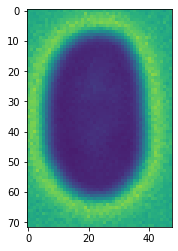

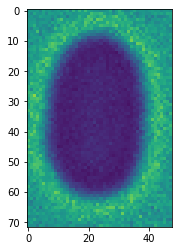

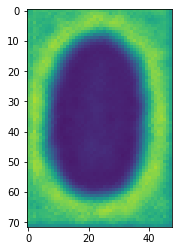

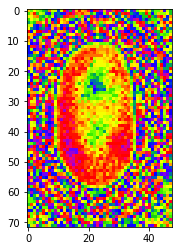

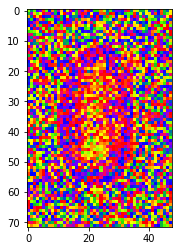

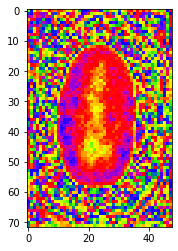

Epoch: 4, Discriminator loss: 0.16003323609338088
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [5/30] Batch [500/542] Discriminator loss: 0.6260977983474731 Generator loss: 0.7860681414604187


  0%|          | 0/136 [00:00<?, ?it/s]

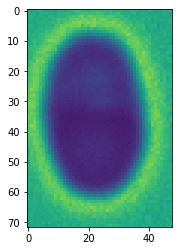

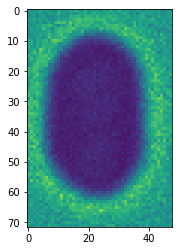

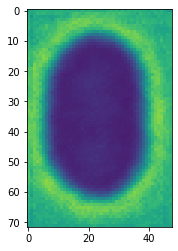

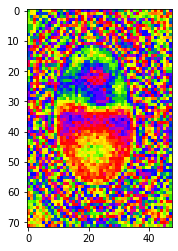

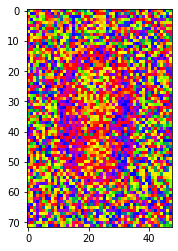

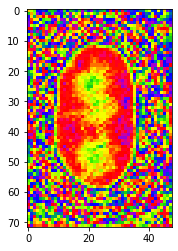

Epoch: 5, Discriminator loss: 0.11721437950344647
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [6/30] Batch [500/542] Discriminator loss: 0.5472614765167236 Generator loss: 0.9191514253616333


  0%|          | 0/136 [00:00<?, ?it/s]

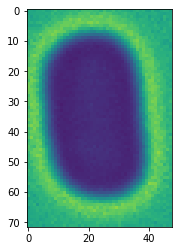

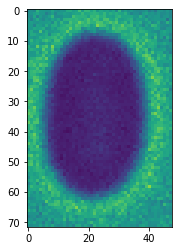

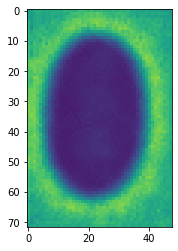

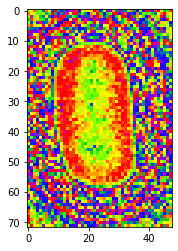

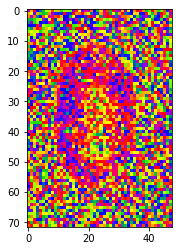

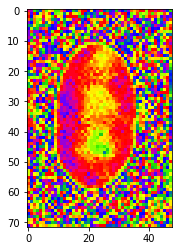

Epoch: 6, Discriminator loss: 0.02456979179645286
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [7/30] Batch [500/542] Discriminator loss: 0.43126267194747925 Generator loss: 1.0311626195907593


  0%|          | 0/136 [00:00<?, ?it/s]

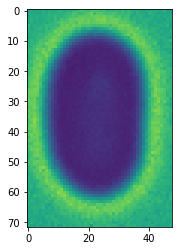

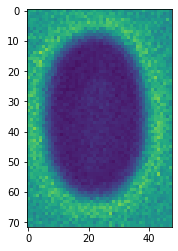

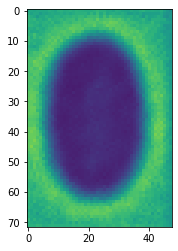

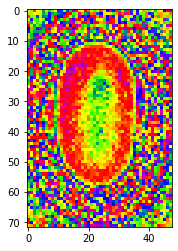

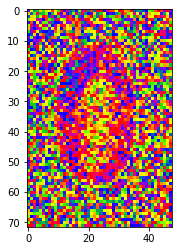

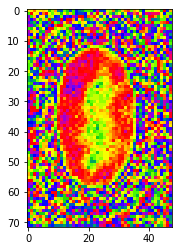

Epoch: 7, Discriminator loss: 0.01787220379885505
Save!!


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [8/30] Batch [500/542] Discriminator loss: 0.4870721995830536 Generator loss: 1.165132761001587


  0%|          | 0/136 [00:00<?, ?it/s]

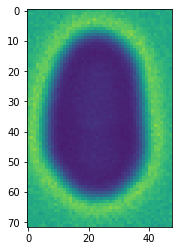

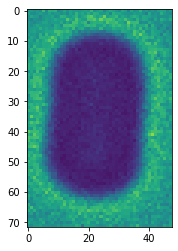

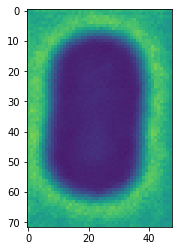

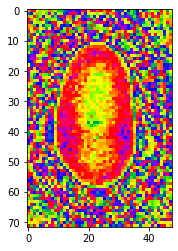

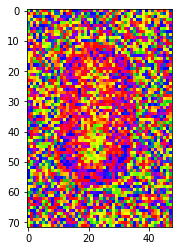

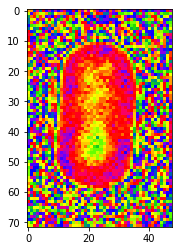

Epoch: 8, Discriminator loss: 0.05951437660876442


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [9/30] Batch [500/542] Discriminator loss: 0.4333805739879608 Generator loss: 1.119459867477417


  0%|          | 0/136 [00:00<?, ?it/s]

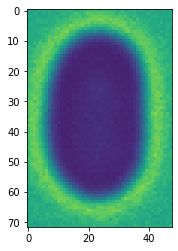

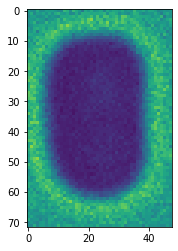

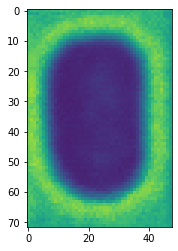

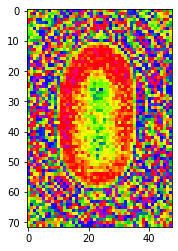

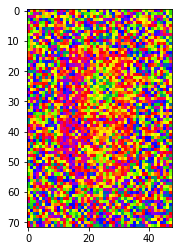

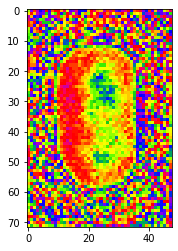

Epoch: 9, Discriminator loss: 0.02793295111726312


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [10/30] Batch [500/542] Discriminator loss: 0.5161072611808777 Generator loss: 0.9480764865875244


  0%|          | 0/136 [00:00<?, ?it/s]

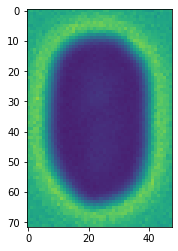

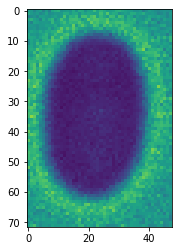

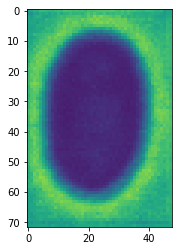

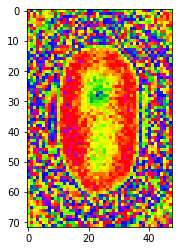

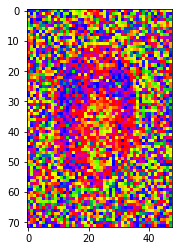

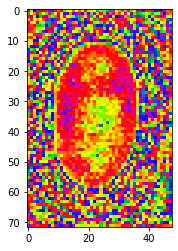

Epoch: 10, Discriminator loss: 0.03724775583866764


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [12/30] Batch [500/542] Discriminator loss: 0.4613180458545685 Generator loss: 1.227972388267517


  0%|          | 0/136 [00:00<?, ?it/s]

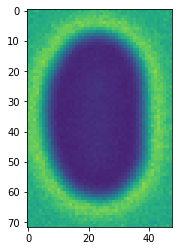

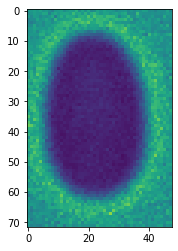

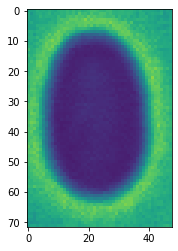

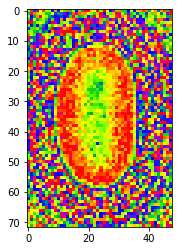

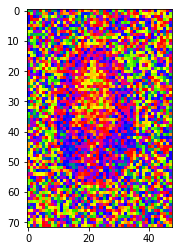

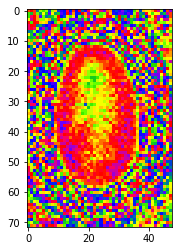

Epoch: 12, Discriminator loss: 0.025663917555528527


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [13/30] Batch [500/542] Discriminator loss: 0.44425225257873535 Generator loss: 1.2787833213806152


  0%|          | 0/136 [00:00<?, ?it/s]

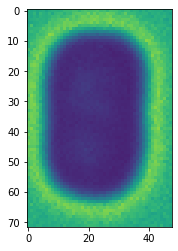

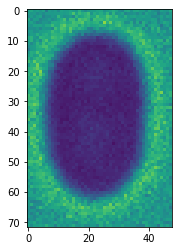

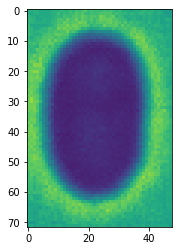

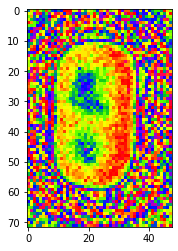

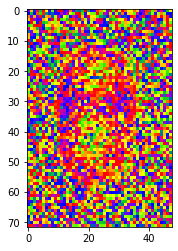

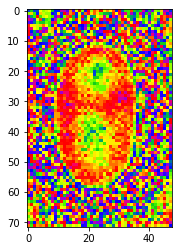

Epoch: 13, Discriminator loss: 0.02187288925051689


  0%|          | 0/542 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [23/30] Batch [500/542] Discriminator loss: 0.5404210686683655 Generator loss: 0.8463244438171387


  0%|          | 0/136 [00:00<?, ?it/s]

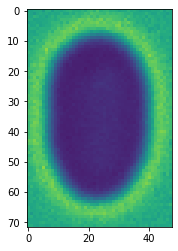

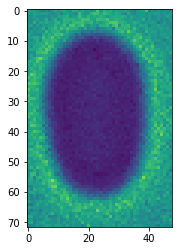

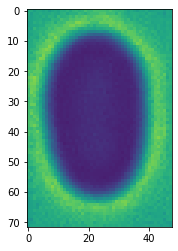

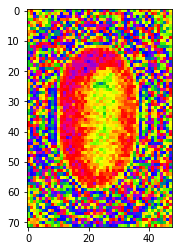

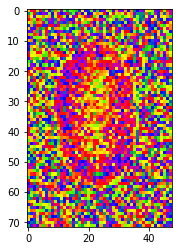

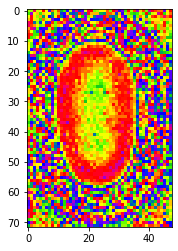

Epoch: 23, Discriminator loss: 0.0273422513376264


  0%|          | 0/542 [00:00<?, ?it/s]

Epoch [24/30] Batch [500/542] Discriminator loss: 0.4337313771247864 Generator loss: 0.9781528115272522


  0%|          | 0/136 [00:00<?, ?it/s]

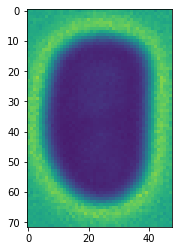

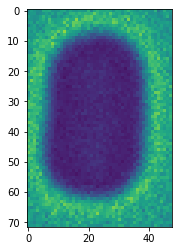

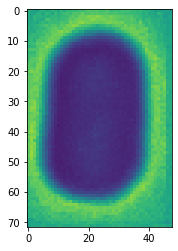

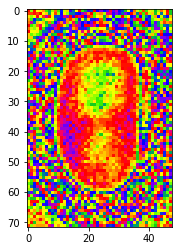

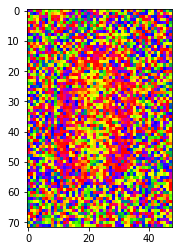

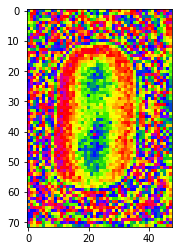

Epoch: 24, Discriminator loss: 0.023836391594480064


  0%|          | 0/542 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
criterion = nn.BCELoss()
g_loss_list = []
d_loss_list = []
best_score = 100
best_model_g = None
best_model_d = None
for epoch in range(1, CFG['EPOCHS']+1):
    generator.train()
    discriminator.train()
    
    train_loss = []
    i = 0
    for sem, dep, tr in tqdm(iter(train_loader)):

        tr = tr.float().to(device)
        valid_label = torch.ones((tr.shape[0], 1), device=device, dtype = torch.float32)
        
        z = torch.randn((tr.shape[0], tr.shape[1], tr.shape[2], tr.shape[3]), device = device)
        z = torch.cat([sem.float().to(device), dep.float().to(device),z ], axis=1)        
        gen_img = generator(z)        
        fake_label = torch.zeros((tr.shape[0], 1), device=device, dtype = torch.float32)


        real_loss = criterion(discriminator(tr), valid_label)
        fake_loss = criterion(discriminator(gen_img.detach()), fake_label)
        d_loss = (real_loss + fake_loss) * 0.5

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        g_loss = criterion(discriminator(gen_img), valid_label)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()            

        if (i+1) % 500 == 0:
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            print("Epoch [{}/{}] Batch [{}/{}] Discriminator loss: {} Generator loss: {}".format(epoch, CFG['EPOCHS'], i+1, len(train_loader), d_loss.item(), g_loss.item()))
        i += 1
    if epoch % 1 == 0:
        generator.eval()
        discriminator.eval()
        val_loss = []
        
        with torch.no_grad():
            cnt = 0
            for sem, dep, tr in tqdm(iter(val_loader)):
                tr = tr.float().to(device)
                valid_label = torch.ones((tr.shape[0], 1), device=device, dtype = torch.float32)
                
                z = torch.randn((tr.shape[0], tr.shape[1], tr.shape[2], tr.shape[3]), device = device)
                z = torch.cat([sem.float().to(device), dep.float().to(device), z], axis=1)        
                gen_img = generator(z)    
                fake_label = torch.zeros((tr.shape[0], 1), device=device, dtype = torch.float32)
                
                real_loss = criterion(discriminator(tr), valid_label)
                fake_loss = criterion(discriminator(gen_img.detach()), fake_label)
                val_loss.append(np.abs((real_loss.item() + fake_loss.item())  * 0.5 - 0.5))
                
                cnt+=1
                if cnt == 1:
                    plt.imshow(tr[0][0].cpu().detach().numpy(), vmin= 0, vmax=1)
                    plt.show()
                    plt.imshow(sem[0][0].cpu().detach().numpy(), vmin= 0, vmax=1)
                    plt.show()
                    plt.imshow(gen_img[0][0].cpu().detach().numpy(), vmin= 0, vmax=1)
                    plt.show()
                    plt.imshow(tr[0][0].cpu().detach().numpy()  , cmap = 'prism', vmin= 0, vmax=1)
                    plt.show()
                    plt.imshow(sem[0][0].cpu().detach().numpy()  , cmap = 'prism', vmin= 0, vmax=1)
                    plt.show()
                    plt.imshow(gen_img[0][0].cpu().detach().numpy()  , cmap = 'prism', vmin= 0, vmax=1)
                    plt.show()
        val_error = np.mean(val_loss)
        print("Epoch: {}, Discriminator loss: {}".format(epoch, val_error))
        
        if best_score > val_error:
            best_score = val_error
            torch.save(generator.state_dict(), "./weight/generator_state_dict4.pt")
            torch.save(discriminator.state_dict(), "./weight/discriminator_state_dict4.pt")        
            print("Save!!")

In [21]:
generator = Generator().to(device)
generator.load_state_dict(torch.load('./weight/generator_state_dict4.pt'))

<All keys matched successfully>

In [22]:
simulation_sem_paths[0][:-4]+'_gen.png'

'./data/simulation_data/SEM/Case_4/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr0_gen.png'

idx: 1 path:  ./data/simulation_data/SEM/Case_4/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr1.png


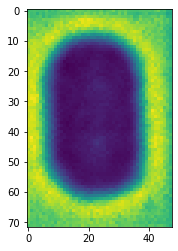

idx: 1001 path:  ./data/simulation_data/SEM/Case_4/80/20201205_031451_NE142400C_RAA0A_1_S01_M0133-01MS_0_itr1.png


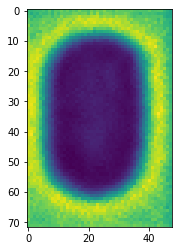

idx: 2001 path:  ./data/simulation_data/SEM/Case_4/80/20201219_205018_NE142400C_RAA0J_2_S13_M0178-01MS_3_itr1.png


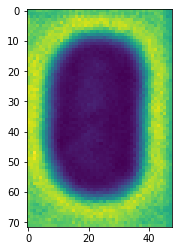

idx: 3001 path:  ./data/simulation_data/SEM/Case_4/80/20210113_072317_NE142400C_RAM0H_1_S01_M0085-01MS_0_itr1.png


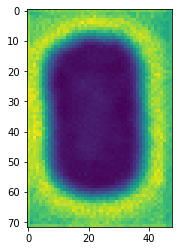

idx: 4001 path:  ./data/simulation_data/SEM/Case_4/80/20210209_031719_NE142400C_RAE14_2_S07_M0113-01MS_2_itr1.png


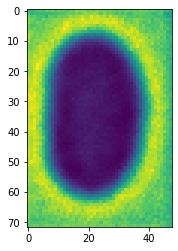

idx: 5001 path:  ./data/simulation_data/SEM/Case_4/80/20210316_080344_NE142400C_RAA21_1_S05_M0214-01MS_1_itr1.png


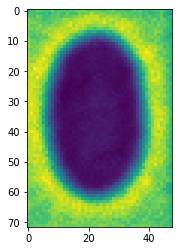

idx: 6001 path:  ./data/simulation_data/SEM/Case_4/81/20201105_031319_NE142400C_RAE05_1_S01_M0192-01MS_3_itr1.png


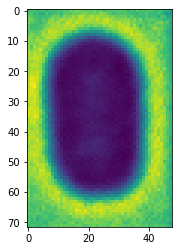

idx: 7001 path:  ./data/simulation_data/SEM/Case_4/81/20201212_075845_NE142400C_RAM0R_1_S15_M0242-01MS_3_itr1.png


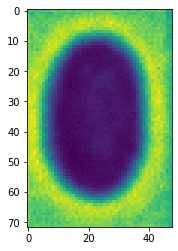

idx: 8001 path:  ./data/simulation_data/SEM/Case_4/81/20210106_093118_NE142400C_RAA0H_1_S02_M0061-01MS_3_itr1.png


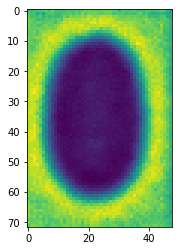

idx: 9001 path:  ./data/simulation_data/SEM/Case_4/81/20210114_072519_NE142400C_RAA14_2_S09_M0206-01MS_2_itr1.png


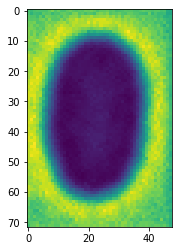

idx: 10001 path:  ./data/simulation_data/SEM/Case_4/81/20210213_030800_NE142400C_RAA0S_1_S01_M0183-01MS_1_itr1.png


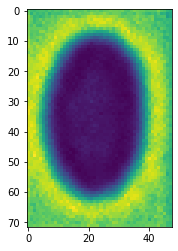

idx: 11001 path:  ./data/simulation_data/SEM/Case_4/81/20210302_082541_NE142400C_RAA0TH_1_S10_M0121-01MS_2_itr1.png


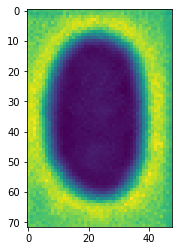

idx: 12001 path:  ./data/simulation_data/SEM/Case_4/81/20210318_110531_NE142400C_RAE12_1_S20_M0152-01MS_3_itr1.png


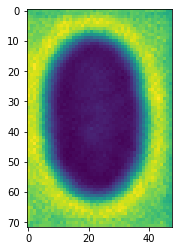

idx: 13001 path:  ./data/simulation_data/SEM/Case_4/82/20201105_031319_NE142400C_RAE05_1_S01_M0214-01MS_1_itr1.png


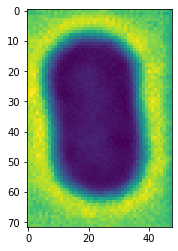

idx: 14001 path:  ./data/simulation_data/SEM/Case_4/82/20201219_130240_NE142400C_RAA0J_2_S02_M0099-01MS_3_itr1.png


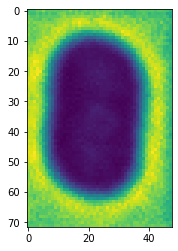

idx: 15001 path:  ./data/simulation_data/SEM/Case_4/82/20210110_172304_NE142400C_RAM1NI_1_S10_M0117-01MS_3_itr1.png


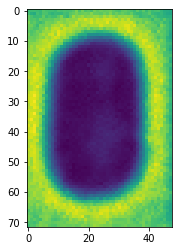

idx: 16001 path:  ./data/simulation_data/SEM/Case_4/82/20210114_183335_NE142400C_RAM1B_1_S03_M0005-01MS_3_itr1.png


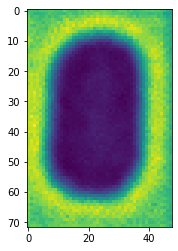

idx: 17001 path:  ./data/simulation_data/SEM/Case_4/82/20210207_103243_NE142400C_RAA1I_63_S06_M0180-01MS_2_itr1.png


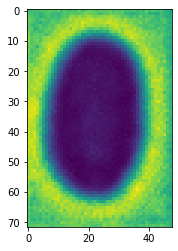

idx: 18001 path:  ./data/simulation_data/SEM/Case_4/82/20210220_101758_NE142400C_RAE0H_1_S01_M0087-01MS_2_itr1.png


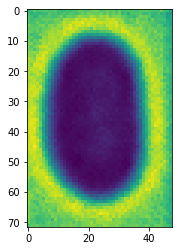

idx: 19001 path:  ./data/simulation_data/SEM/Case_4/82/20210228_090349_NE142400C_RAM2L_1_S06_M0056-01MS_3_itr1.png


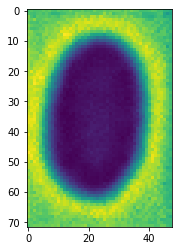

idx: 20001 path:  ./data/simulation_data/SEM/Case_4/82/20210315_025821_NE142400C_RAM1R_1_S05_M0092-01MS_3_itr1.png


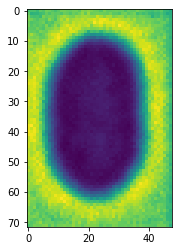

idx: 21001 path:  ./data/simulation_data/SEM/Case_4/82/20210322_032730_NE142400C_RAM2H_1_S06_M0245-01MS_3_itr1.png


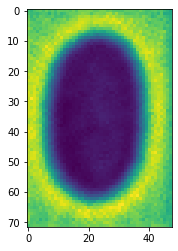

idx: 22001 path:  ./data/simulation_data/SEM/Case_4/83/20201105_031319_NE142400C_RAE05_1_S01_M0021-01MS_0_itr1.png


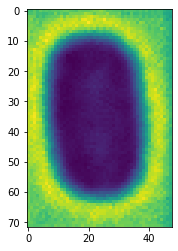

idx: 23001 path:  ./data/simulation_data/SEM/Case_4/83/20201220_014340_NE142400C_RAM0J_1_S01_M0154-01MS_3_itr1.png


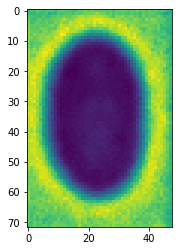

idx: 24001 path:  ./data/simulation_data/SEM/Case_4/83/20210113_043415_NE142400C_RAA0U_1_S01_M0243-01MS_0_itr1.png


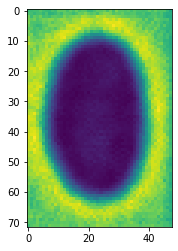

idx: 25001 path:  ./data/simulation_data/SEM/Case_4/83/20210116_114244_NE142400C_RAE0B_1_S02_M0214-01MS_0_itr1.png


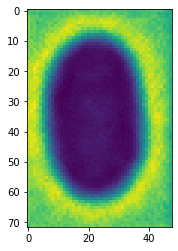

idx: 26001 path:  ./data/simulation_data/SEM/Case_4/83/20210204_203618_NE142400C_RAA1H_1_S07_M0307-01MS_2_itr1.png


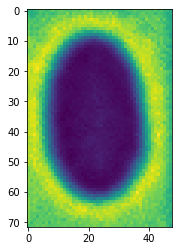

idx: 27001 path:  ./data/simulation_data/SEM/Case_4/83/20210216_090716_NE142400C_RAE0OE_1_S12_M0020-01MS_1_itr1.png


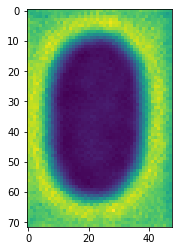

idx: 28001 path:  ./data/simulation_data/SEM/Case_4/83/20210225_175004_NE142400C_RAE0E_1_S01_M0175-01MS_1_itr1.png


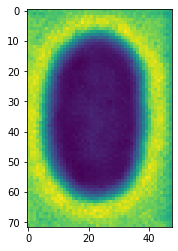

idx: 29001 path:  ./data/simulation_data/SEM/Case_4/83/20210301_060120_NE142400C_RAA1R_1_S05_M0214-01MS_2_itr1.png


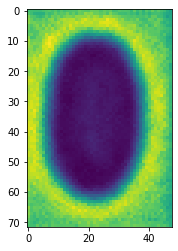

idx: 30001 path:  ./data/simulation_data/SEM/Case_4/83/20210316_080344_NE142400C_RAA21_1_S05_M0377-01MS_0_itr1.png


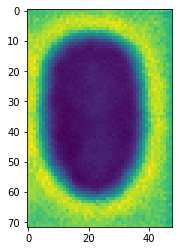

idx: 31001 path:  ./data/simulation_data/SEM/Case_4/83/20210322_032730_NE142400C_RAM2H_1_S06_M0206-01MS_2_itr1.png


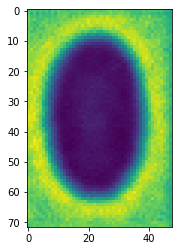

idx: 32001 path:  ./data/simulation_data/SEM/Case_4/83/20210402_155723_NE142400C_RAA0Z_1_S12_M0240-01MS_0_itr1.png


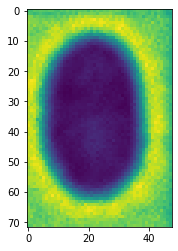

idx: 33001 path:  ./data/simulation_data/SEM/Case_4/84/20201221_123611_NE142400C_RAA07C_2_S11_M0148-01MS_3_itr1.png


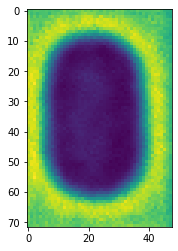

idx: 34001 path:  ./data/simulation_data/SEM/Case_4/84/20210113_072317_NE142400C_RAM0H_1_S01_M0154-01MS_2_itr1.png


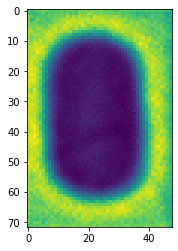

idx: 35001 path:  ./data/simulation_data/SEM/Case_4/84/20210116_114244_NE142400C_RAE0B_1_S02_M0057-01MS_0_itr1.png


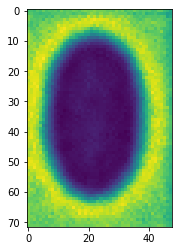

idx: 36001 path:  ./data/simulation_data/SEM/Case_4/84/20210201_091907_NE142400C_RAE0U_1_S01_M0371-01MS_2_itr1.png


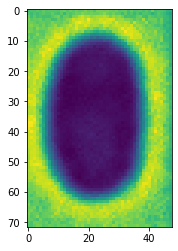

idx: 37001 path:  ./data/simulation_data/SEM/Case_4/84/20210214_041502_NE142400C_RAA0S_2_S02_M0247-01MS_2_itr1.png


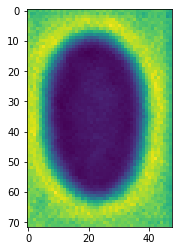

idx: 38001 path:  ./data/simulation_data/SEM/Case_4/84/20210220_234815_NE142400C_RAA1K_1_S01_M0381-01MS_0_itr1.png


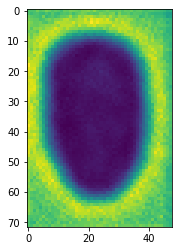

idx: 39001 path:  ./data/simulation_data/SEM/Case_4/84/20210227_035705_NE142400C_RAM1A_1_S06_M0341-01MS_0_itr1.png


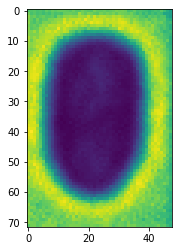

idx: 40001 path:  ./data/simulation_data/SEM/Case_4/84/20210304_165053_NE142400C_RAA26_1_S01_M0302-01MS_3_itr1.png


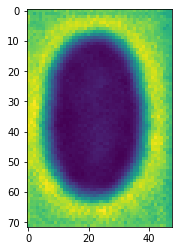

idx: 41001 path:  ./data/simulation_data/SEM/Case_4/84/20210316_101925_NE142400C_RAA1C_1_S07_M0051-01MS_0_itr1.png


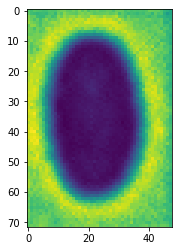

idx: 42001 path:  ./data/simulation_data/SEM/Case_4/84/20210322_035118_NE142400C_RAA2J_1_S07_M0118-01MS_0_itr1.png


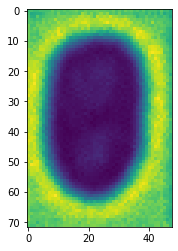

idx: 43001 path:  ./data/simulation_data/SEM/Case_4/84/20210329_235628_NE142400C_RAE09_1_S01_M0369-01MS_0_itr1.png


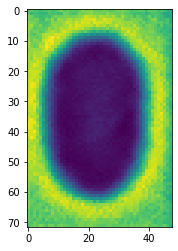

In [23]:
for idx, i in enumerate(simulation_sem_paths):

    sem_img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
    sem_img = sem_img / 255.
    sem_img = torch.tensor(sem_img, device = device).unsqueeze(0)
    
    dep = cv2.imread(simulation_depth_paths[idx], cv2.IMREAD_GRAYSCALE)
    dep = np.expand_dims(dep, axis=-1).transpose(2,0,1)
    dep = dep / 255.
    dep = torch.tensor(dep, device = device).unsqueeze(0)
    
    
    z = torch.randn((sem_img.shape[0], sem_img.shape[1], sem_img.shape[2], sem_img.shape[3]), device = device)
    z = torch.cat([sem_img.float().to(device), dep.float().to(device), z], axis=1)        
    gen_img = generator(z)
    
    save_image(gen_img[0].cpu().detach(), i[:-4]+'_gen.png')
    
    if idx% 1000 == 1:
        print('idx:', idx, 'path: ', i)
        plt.imshow(gen_img[0][0].cpu().detach().numpy())
        plt.show()